In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import transformers
from transformers import get_linear_schedule_with_warmup
from seqeval.metrics import f1_score, accuracy_score

# from transformers import BertTokenizer, BertConfig
# from transformers import BertForTokenClassification, AdamW

from transformers import RobertaConfig, RobertaModel
from transformers import RobertaTokenizer, RobertaForTokenClassification, AutoTokenizer, AdamW


2023-07-19 16:55:13.372704: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 16:55:13.894119: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Check GPU availability

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2080 Ti'

# **Preprocessing data**

In [3]:
# Reading data
import json


#open the file, and format correctly
f =open('dataset.jsonl', 'r')
json_object = json.dumps(f.readlines(), indent=4)
f.close()

#save better format into file
p = open('sample.txt', 'w')
for i in json_object:
    p.write(i)
p.close()

#open new file, and save each 
j = open('sample.txt', 'r')
text = json.loads(j.read())
j.close()

#compile all json dicts into a list
info = []
for i in text:
    info.append(json.loads(str(i)))
    

In [4]:
# To use the BERT, you must use the BERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/roberta-large-ner-english")


In [5]:
def degreekify(char):
    #char will be a character
    greek = {'α': '[alpha]', 'β':'[beta]', 'γ': '[gamma]', 'δ':'[delta]', 'ε': '[epsilon]', 'ζ':'[zeta]', 'η': '[eta]',
            'θ':'[theta]', 'ι': '[iota]', 'κ':'[kappa]', 'λ':'[lambda]', 'μ': '[mu]', 'ν':'[nu]', 'ξ':'[xi]', 'ο':'[omicron]', 'π':'[pi]', 'ρ':'[rho]',
            'σ': '[sigma]', 'τ': '[tau]', 'υ':'[upsilon]', 'φ':'[phi]', 'χ':'[chi]', 'ψ':'[psi]', 'ω':'[omega]' }
    if char in greek:
        return greek[char]
    else:
        return char

In [6]:
def pre_process(text, annotations):
    #text will be the straight sentence, info[i]['text']
    #annotations will be the list of labels, must be info[i]['annotations']
    
    text_dict = []
    
    for i in range(len(text)):
        text_dict.append(degreekify(text[i]))
    
    
    
    ann_indices = []
    def fun(x):
        return x['start_offset']
    annotations.sort(key=fun)
    
    
    
    if len(annotations)==0:
        ann_indices.append([[0, len(text)],0])
    else:
        ann_indices.append([[0, annotations[0]['start_offset']], 0])
        for i in range(len(annotations)-1):
            ann_indices.append([[annotations[i]['start_offset'], annotations[i]['end_offset']], annotations[i]['label']])
            ann_indices.append([[annotations[i]['end_offset'], annotations[i+1]['start_offset']], 0])
            
        ann_indices.append([[annotations[-1]['start_offset'], annotations[-1]['end_offset']], annotations[-1]['label']])
        ann_indices.append([[annotations[-1]['end_offset'], len(text)], 0])
         
    
    labels = []
    sentences = []
    for a in ann_indices:
        
        if a[0][1]-a[0][0] !=0:
            together = ''
            for i in range(a[0][0], a[0][1]):
                together += text_dict[i]
                
            toke = together.split()
            sentences.extend(toke)
            t = len(toke)
            if t != 0:
                temp = [data_tags[2 * a[1]]] * t
                if a[1] != 0:
                    temp[0] = data_tags[2 * a[1]-1]
                labels.extend(temp)
 
    return labels, sentences

In [7]:
#create labels
data_tags = ['0','C', 'C-cont' , 'M', 'M-cont', 'Q', 'Q-cont', 'T' , 'T-cont', 'A' , 'A-cont', 'R', 'R-cont']

sentences, labels = [], []

for i in range(len(info)):
    l,s = pre_process(info[i]['text'], info[i]['annotations'])
    if len(l) != len(s):
        print('fuck')
    else:
        labels.append(l)
        sentences.append(s)

In [8]:

for i in range(5):
    s, l = sentences[i], labels[i]
    if len(l) != len(s):
        print('fuck')
    else:
        for j in range(len(l)):
            print(l[j],s[j])
    

0 The
0 influence
0 of
R [gamma]-radiation
0 on
0 the
0 physical
0 characteristics
0 and
0 sorption
0 properties
0 for
M Am
0 of
0 the
0 solid
0 extractant
C AXIONIT
C-cont MND
C-cont 40T
0 (
C TVEX
0 )
0 synthesized
0 by
0 Axion-Rare
0 and
0 Noble
0 Metals
0 JSC
0 (Perm)
0 was
0 studied.
0 With
0 an
0 increase
0 of
0 the
0 absorbed
0 dose
0 of
R [gamma]-radiation
0 ,
0 the
0 granulometric
0 composition,
0 bulk
0 density,
0 and
0 specific
0 volume
0 of
C TVEX
0 change
0 insignificantly.
0 The
0 IR
0 spectra
0 of
C TVEX
0 demonstrate
0 significant
0 radiation
0 degradation
0 at
0 an
0 absorbed
0 radiation
0 dose
0 from
Q 1.4
Q-cont to
Q-cont 2.5
Q-cont MGy
0 .
C TVEX
0 is
0 an
0 effective
M Am
0 sorbent
0 when
0 irradiated
0 to
0 an
0 absorbed
R [gamma]-radiation
0 dose
0 of
0 no
0 more
0 than
Q 0.6
Q-cont MGy
0 .
0 At
0 an
0 irradiation
0 dose
0 of
Q 2.5
Q-cont MGy
0 sorption
0 capacity
0 is
0 significantly
0 reduced.
0 Basic
0 physicochemical
0 properties
0 of
0 the
C TVEX
0 sample
0 

In [9]:

# Determine the list of tags
tag_values = data_tags
print(tag_values)

tag_values.append("PAD")
print(tag_values)

tag2idx = {t: i for i, t in enumerate(tag_values)}
print(tag2idx)
     

['0', 'C', 'C-cont', 'M', 'M-cont', 'Q', 'Q-cont', 'T', 'T-cont', 'A', 'A-cont', 'R', 'R-cont']
['0', 'C', 'C-cont', 'M', 'M-cont', 'Q', 'Q-cont', 'T', 'T-cont', 'A', 'A-cont', 'R', 'R-cont', 'PAD']
{'0': 0, 'C': 1, 'C-cont': 2, 'M': 3, 'M-cont': 4, 'Q': 5, 'Q-cont': 6, 'T': 7, 'T-cont': 8, 'A': 9, 'A-cont': 10, 'R': 11, 'R-cont': 12, 'PAD': 13}


In [10]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [11]:
tokenized_texts_and_labels = [ tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(sentences, labels)]

tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [12]:
# MAX_LEN is the maximum length of a sequence
MAX_LEN = 128 # 64 or 128 or ...
bs = 6 # batch size


In [13]:
# Use Padding to equalize the length of sentences
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
     

In [14]:
# Do not mask values that are zero
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [15]:
# Split data to train and validation. %90 for train and %10 for validation
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)

# Each mask contains 10% of a sentence
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

# The input of the BERT should be the tensors produced using PyTorch
# So convert all inputs and labels into torch tensors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)

tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)

tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

# Create the DataLoader for our training set
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

print(train_sampler)

# Create the DataLoader for our validation set
valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


# **Build model**

In [16]:
# Load RoBERTa Model
from transformers import AutoTokenizer, AutoModelForTokenClassification
model = AutoModelForTokenClassification.from_pretrained(
    "roberta-base",
    num_labels=len(tag2idx), # The number of output labels
    output_attentions = False, # Whether the model returns attention weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
    
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions

In [17]:
# Tell PyTorch to run this model on the GPU
model.cuda();

In [18]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr= 3e-6, # learning-rate default is 3e-5
    eps=1e-8 # adam-epsilon default is 1e-8
)


/home/ecasey/anaconda3/envs/torch/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [19]:
epochs = 150

max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=30,
    num_training_steps=total_steps
)

# **Training**

In [20]:
def acc(print_labels, special):
    accuracy_list = []
    max_a = 0
    index_a = 1000000
    
    for i in range(len(sentences)):
       
        temp = []
        for j in range(len(sentences[i])):
            temp.extend(tokenizer.tokenize(sentences[i][j]))
        
        temp1 = []
     
        for j in range(len(temp)):
            t = tokenizer.convert_tokens_to_ids(temp[j])
            temp1.append(t)
            
        tokenized_sentence = temp1
        input_ids = torch.tensor([tokenized_sentence]).cuda()

        with torch.no_grad():
            output = model(input_ids)

        label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

        # join bpe split tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
        new_tokens, new_labels = [], []
        for token, label_idx in zip(tokens, label_indices[0]):
            if token.startswith("##"):
                new_tokens[-1] = new_tokens[-1] + token[2:]
            else:
                new_labels.append(tag_values[label_idx])
                new_tokens.append(token)

        new_labels = new_labels[1:-1]
        a = accuracy_score(new_labels, labels[i])
        if a  >= max_a and i !=4:
            max_a = a
            index_a = i
          
        accuracy_list.append(a)
        if print_labels == True:
            print("___________________"+ str(i)+"___________________")
            print("\nPredict labels: ",new_labels)
            print("Actual labels: ",labels[i])
            print()
            print()
            if special == i:
                for j in range(len(sentences[i])):
                    print(sentences[i][j], new_labels[j])
    print(index_a, max_a)
    return statistics.mean(accuracy_list)
        


In [21]:
## Store the average loss after each epoch so we can plot them.
import copy
loss_values, validation_loss_values = [], []

test_acc = []

max_test = 10

for e in trange(epochs, desc="Epoch"):
    
    
    
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("\nAverage train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("\nValidation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]

    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    #print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()
    a = eval_loss
    test_acc.append(a)
    if a <= max_test:
        max_test = a
    elif a * 1.2 == max_test:
        f = open("text.ck", "w")
        torch.save(model, "test.ck")
        f.close()

Epoch:   1%|█▌                                                                                                                                                                                                                                          | 1/150 [00:02<05:08,  2.07s/it]


Average train loss: 2.4808708000183106

Validation loss: 2.3523851235707602
Validation Accuracy: 0.5093603744149766



Epoch:   1%|███▏                                                                                                                                                                                                                                        | 2/150 [00:03<04:28,  1.81s/it]


Average train loss: 2.062639899253845

Validation loss: 1.7239963213602703
Validation Accuracy: 0.6505460218408736



Epoch:   2%|████▋                                                                                                                                                                                                                                       | 3/150 [00:05<04:14,  1.73s/it]


Average train loss: 1.4392046165466308

Validation loss: 1.0053889552752178
Validation Accuracy: 0.6497659906396256



Epoch:   3%|██████▎                                                                                                                                                                                                                                     | 4/150 [00:06<04:07,  1.70s/it]


Average train loss: 0.9138414573669433

Validation loss: 0.6397874454657236
Validation Accuracy: 0.6731669266770671



Epoch:   3%|███████▊                                                                                                                                                                                                                                    | 5/150 [00:08<04:03,  1.68s/it]


Average train loss: 0.7135542702674865

Validation loss: 0.5283158421516418
Validation Accuracy: 0.7379095163806553



Epoch:   4%|█████████▍                                                                                                                                                                                                                                  | 6/150 [00:10<03:59,  1.67s/it]


Average train loss: 0.577842743396759

Validation loss: 0.45911481976509094
Validation Accuracy: 0.766770670826833



Epoch:   5%|███████████                                                                                                                                                                                                                                 | 7/150 [00:11<03:56,  1.66s/it]


Average train loss: 0.503728699684143

Validation loss: 0.3996848265329997
Validation Accuracy: 0.8198127925117005



Epoch:   5%|████████████▌                                                                                                                                                                                                                               | 8/150 [00:13<03:54,  1.65s/it]


Average train loss: 0.4362368452548981

Validation loss: 0.3616352528333664
Validation Accuracy: 0.8237129485179407



Epoch:   6%|██████████████▏                                                                                                                                                                                                                             | 9/150 [00:15<03:52,  1.65s/it]


Average train loss: 0.38379761278629304

Validation loss: 0.3272121647993724
Validation Accuracy: 0.8408736349453978



Epoch:   7%|███████████████▋                                                                                                                                                                                                                           | 10/150 [00:16<03:51,  1.65s/it]


Average train loss: 0.3538829481601715

Validation loss: 0.30280592540899914
Validation Accuracy: 0.8502340093603744



Epoch:   7%|█████████████████▏                                                                                                                                                                                                                         | 11/150 [00:18<03:49,  1.65s/it]


Average train loss: 0.32651243805885316

Validation loss: 0.2838307172060013
Validation Accuracy: 0.8611544461778471



Epoch:   8%|██████████████████▊                                                                                                                                                                                                                        | 12/150 [00:20<03:47,  1.65s/it]


Average train loss: 0.3089830559492111

Validation loss: 0.2710712303717931
Validation Accuracy: 0.8549141965678627



Epoch:   9%|████████████████████▎                                                                                                                                                                                                                      | 13/150 [00:21<03:45,  1.65s/it]


Average train loss: 0.27910529911518095

Validation loss: 0.2643446971972783
Validation Accuracy: 0.8502340093603744



Epoch:   9%|█████████████████████▉                                                                                                                                                                                                                     | 14/150 [00:23<03:43,  1.64s/it]


Average train loss: 0.2689847755432129

Validation loss: 0.24925746272007623
Validation Accuracy: 0.8564742589703588



Epoch:  10%|███████████████████████▌                                                                                                                                                                                                                   | 15/150 [00:25<03:41,  1.64s/it]


Average train loss: 0.2416416896879673

Validation loss: 0.24392877767483392
Validation Accuracy: 0.8627145085803433



Epoch:  11%|█████████████████████████                                                                                                                                                                                                                  | 16/150 [00:26<03:40,  1.64s/it]


Average train loss: 0.22931788086891175

Validation loss: 0.2264553407828013
Validation Accuracy: 0.874414976599064



Epoch:  11%|██████████████████████████▋                                                                                                                                                                                                                | 17/150 [00:28<03:38,  1.64s/it]


Average train loss: 0.2269056412577629

Validation loss: 0.22274698813756308
Validation Accuracy: 0.874414976599064



Epoch:  12%|████████████████████████████▏                                                                                                                                                                                                              | 18/150 [00:30<03:37,  1.65s/it]


Average train loss: 0.20961234726011754

Validation loss: 0.21319792419672012
Validation Accuracy: 0.8829953198127926



Epoch:  13%|█████████████████████████████▊                                                                                                                                                                                                             | 19/150 [00:31<03:35,  1.65s/it]


Average train loss: 0.19954586237668992

Validation loss: 0.21074565003315607
Validation Accuracy: 0.8837753510140406



Epoch:  13%|███████████████████████████████▎                                                                                                                                                                                                           | 20/150 [00:33<03:34,  1.65s/it]


Average train loss: 0.1855210742354393

Validation loss: 0.20602083951234818
Validation Accuracy: 0.8868954758190327



Epoch:  14%|████████████████████████████████▉                                                                                                                                                                                                          | 21/150 [00:34<03:32,  1.65s/it]


Average train loss: 0.17933037012815475

Validation loss: 0.1963227316737175
Validation Accuracy: 0.890795631825273



Epoch:  15%|██████████████████████████████████▍                                                                                                                                                                                                        | 22/150 [00:36<03:31,  1.65s/it]


Average train loss: 0.16983991771936416

Validation loss: 0.19685679177443186
Validation Accuracy: 0.8876755070202809



Epoch:  15%|████████████████████████████████████                                                                                                                                                                                                       | 23/150 [00:38<03:29,  1.65s/it]


Average train loss: 0.1570856399834156

Validation loss: 0.2031617909669876
Validation Accuracy: 0.8861154446177847



Epoch:  16%|█████████████████████████████████████▌                                                                                                                                                                                                     | 24/150 [00:39<03:27,  1.65s/it]


Average train loss: 0.15641849637031555

Validation loss: 0.18969908356666565
Validation Accuracy: 0.890015600624025



Epoch:  17%|███████████████████████████████████████▏                                                                                                                                                                                                   | 25/150 [00:41<03:26,  1.65s/it]


Average train loss: 0.14501508951187134

Validation loss: 0.1893036092321078
Validation Accuracy: 0.8954758190327613



Epoch:  17%|████████████████████████████████████████▋                                                                                                                                                                                                  | 26/150 [00:43<03:24,  1.65s/it]


Average train loss: 0.13699322503060102

Validation loss: 0.1820245881875356
Validation Accuracy: 0.9024960998439937



Epoch:  18%|██████████████████████████████████████████▎                                                                                                                                                                                                | 27/150 [00:44<03:23,  1.65s/it]


Average train loss: 0.1306999507546425

Validation loss: 0.18471098442872366
Validation Accuracy: 0.9001560062402496



Epoch:  19%|███████████████████████████████████████████▊                                                                                                                                                                                               | 28/150 [00:46<03:21,  1.65s/it]


Average train loss: 0.12506450057029725

Validation loss: 0.18951709692676863
Validation Accuracy: 0.8993759750390016



Epoch:  19%|█████████████████████████████████████████████▍                                                                                                                                                                                             | 29/150 [00:48<03:20,  1.65s/it]


Average train loss: 0.12195859774947167

Validation loss: 0.18360045552253723
Validation Accuracy: 0.8978159126365055



Epoch:  20%|███████████████████████████████████████████████                                                                                                                                                                                            | 30/150 [00:49<03:18,  1.65s/it]


Average train loss: 0.1110304568707943

Validation loss: 0.18064389129479727
Validation Accuracy: 0.9032761310452418



Epoch:  21%|████████████████████████████████████████████████▌                                                                                                                                                                                          | 31/150 [00:51<03:16,  1.65s/it]


Average train loss: 0.10846451207995415

Validation loss: 0.18539172410964966
Validation Accuracy: 0.9024960998439937



Epoch:  21%|██████████████████████████████████████████████████▏                                                                                                                                                                                        | 32/150 [00:53<03:14,  1.65s/it]


Average train loss: 0.1084790076315403

Validation loss: 0.1862731712559859
Validation Accuracy: 0.9001560062402496



Epoch:  22%|███████████████████████████████████████████████████▋                                                                                                                                                                                       | 33/150 [00:54<03:13,  1.65s/it]


Average train loss: 0.09513517366722227

Validation loss: 0.18173267816503844
Validation Accuracy: 0.9032761310452418



Epoch:  23%|█████████████████████████████████████████████████████▎                                                                                                                                                                                     | 34/150 [00:56<03:11,  1.65s/it]


Average train loss: 0.09070747539401054

Validation loss: 0.1864977888762951
Validation Accuracy: 0.9048361934477379



Epoch:  23%|██████████████████████████████████████████████████████▊                                                                                                                                                                                    | 35/150 [00:58<03:10,  1.66s/it]


Average train loss: 0.0864590633660555

Validation loss: 0.17658403888344765
Validation Accuracy: 0.9040561622464899



Epoch:  24%|████████████████████████████████████████████████████████▍                                                                                                                                                                                  | 36/150 [00:59<03:08,  1.66s/it]


Average train loss: 0.08721786580979823

Validation loss: 0.1839266816775004
Validation Accuracy: 0.906396255850234



Epoch:  25%|█████████████████████████████████████████████████████████▉                                                                                                                                                                                 | 37/150 [01:01<03:07,  1.66s/it]


Average train loss: 0.08367443263530731

Validation loss: 0.1855617215236028
Validation Accuracy: 0.9032761310452418



Epoch:  25%|███████████████████████████████████████████████████████████▌                                                                                                                                                                               | 38/150 [01:03<03:05,  1.66s/it]


Average train loss: 0.0898911403119564

Validation loss: 0.18851852541168532
Validation Accuracy: 0.907176287051482



Epoch:  26%|█████████████████████████████████████████████████████████████                                                                                                                                                                              | 39/150 [01:04<03:04,  1.66s/it]


Average train loss: 0.07251664981245995

Validation loss: 0.17251109580198923
Validation Accuracy: 0.9126365054602185



Epoch:  27%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                            | 40/150 [01:06<03:02,  1.66s/it]


Average train loss: 0.07432529667392374

Validation loss: 0.1819466066857179
Validation Accuracy: 0.9110764430577223



Epoch:  27%|████████████████████████████████████████████████████████████████▏                                                                                                                                                                          | 41/150 [01:08<03:00,  1.66s/it]


Average train loss: 0.06468613259494305

Validation loss: 0.19255790611108145
Validation Accuracy: 0.9102964118564743



Epoch:  28%|█████████████████████████████████████████████████████████████████▊                                                                                                                                                                         | 42/150 [01:09<02:59,  1.66s/it]


Average train loss: 0.06537254825234413

Validation loss: 0.20064320415258408
Validation Accuracy: 0.9079563182527302



Epoch:  29%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 43/150 [01:11<02:57,  1.66s/it]


Average train loss: 0.06160758748650551

Validation loss: 0.18306256458163261
Validation Accuracy: 0.9118564742589703



Epoch:  29%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                      | 44/150 [01:13<02:55,  1.66s/it]


Average train loss: 0.05853039421141148

Validation loss: 0.1982023393114408
Validation Accuracy: 0.9087363494539782



Epoch:  30%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                                                    | 45/150 [01:14<02:54,  1.66s/it]


Average train loss: 0.05497530423104763

Validation loss: 0.18292989085117975
Validation Accuracy: 0.9126365054602185



Epoch:  31%|████████████████████████████████████████████████████████████████████████                                                                                                                                                                   | 46/150 [01:16<02:52,  1.66s/it]


Average train loss: 0.05454577997326851

Validation loss: 0.18814545373121896
Validation Accuracy: 0.9102964118564743



Epoch:  31%|█████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                 | 47/150 [01:18<02:51,  1.66s/it]


Average train loss: 0.05056798055768013

Validation loss: 0.1923218915859858
Validation Accuracy: 0.9149765990639626



Epoch:  32%|███████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 48/150 [01:19<02:49,  1.66s/it]


Average train loss: 0.0462860406935215

Validation loss: 0.1964807783563932
Validation Accuracy: 0.9126365054602185



Epoch:  33%|████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                              | 49/150 [01:21<02:47,  1.66s/it]


Average train loss: 0.04899888087064028

Validation loss: 0.19683163488904634
Validation Accuracy: 0.9149765990639626



Epoch:  33%|██████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                            | 50/150 [01:23<02:45,  1.66s/it]


Average train loss: 0.046738399807363745

Validation loss: 0.1971544623374939
Validation Accuracy: 0.9134165366614665



Epoch:  34%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                           | 51/150 [01:24<02:44,  1.66s/it]


Average train loss: 0.04191535024903715

Validation loss: 0.22817227244377136
Validation Accuracy: 0.9110764430577223



Epoch:  35%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                         | 52/150 [01:26<02:42,  1.66s/it]


Average train loss: 0.04029531426727772

Validation loss: 0.20105686287085214
Validation Accuracy: 0.9149765990639626



Epoch:  35%|███████████████████████████████████████████████████████████████████████████████████                                                                                                                                                        | 53/150 [01:27<02:41,  1.66s/it]


Average train loss: 0.03847041230648756

Validation loss: 0.1890056977669398
Validation Accuracy: 0.9196567862714509



Epoch:  36%|████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                      | 54/150 [01:29<02:39,  1.66s/it]


Average train loss: 0.03831859469413757

Validation loss: 0.20307602112491926
Validation Accuracy: 0.9188767550702028



Epoch:  37%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 55/150 [01:31<02:37,  1.66s/it]


Average train loss: 0.03586053479462862

Validation loss: 0.20206600055098534
Validation Accuracy: 0.9149765990639626



Epoch:  37%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                   | 56/150 [01:32<02:36,  1.66s/it]


Average train loss: 0.035355901904404165

Validation loss: 0.21022992581129074
Validation Accuracy: 0.9149765990639626



Epoch:  38%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                 | 57/150 [01:34<02:34,  1.66s/it]


Average train loss: 0.03339865203946829

Validation loss: 0.20939243709047636
Validation Accuracy: 0.9180967238689548



Epoch:  39%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                | 58/150 [01:36<02:32,  1.66s/it]


Average train loss: 0.033811605721712115

Validation loss: 0.20654564599196115
Validation Accuracy: 0.9180967238689548



Epoch:  39%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 59/150 [01:37<02:31,  1.66s/it]


Average train loss: 0.03876402232795954

Validation loss: 0.20519466449817023
Validation Accuracy: 0.9188767550702028



Epoch:  40%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                             | 60/150 [01:39<02:29,  1.66s/it]


Average train loss: 0.03114831766113639

Validation loss: 0.22028207778930664
Validation Accuracy: 0.9188767550702028



Epoch:  41%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                           | 61/150 [01:41<02:27,  1.66s/it]


Average train loss: 0.029725582972168922

Validation loss: 0.2030479609966278
Validation Accuracy: 0.9196567862714509



Epoch:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                         | 62/150 [01:42<02:26,  1.66s/it]


Average train loss: 0.029128284379839896

Validation loss: 0.22300114979346594
Validation Accuracy: 0.9165366614664586



Epoch:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                        | 63/150 [01:44<02:24,  1.66s/it]


Average train loss: 0.02821402583271265

Validation loss: 0.2136978879570961
Validation Accuracy: 0.9188767550702028



Epoch:  43%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 64/150 [01:46<02:22,  1.66s/it]


Average train loss: 0.02509921185672283

Validation loss: 0.22770508378744125
Validation Accuracy: 0.9141965678627145



Epoch:  43%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                     | 65/150 [01:47<02:21,  1.66s/it]


Average train loss: 0.02513015117496252

Validation loss: 0.21522885064284006
Validation Accuracy: 0.9235569422776911



Epoch:  44%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                   | 66/150 [01:49<02:19,  1.66s/it]


Average train loss: 0.026030474863946437

Validation loss: 0.22372478991746902
Validation Accuracy: 0.9188767550702028



Epoch:  45%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                  | 67/150 [01:51<02:17,  1.66s/it]


Average train loss: 0.024430757947266103

Validation loss: 0.21804334968328476
Validation Accuracy: 0.9212168486739469



Epoch:  45%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                | 68/150 [01:52<02:16,  1.66s/it]


Average train loss: 0.023582616709172725

Validation loss: 0.22770489131410918
Validation Accuracy: 0.9188767550702028



Epoch:  46%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                               | 69/150 [01:54<02:14,  1.66s/it]


Average train loss: 0.022227648287080227

Validation loss: 0.22592170039812723
Validation Accuracy: 0.9212168486739469



Epoch:  47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                             | 70/150 [01:56<02:12,  1.66s/it]


Average train loss: 0.020041354894638062

Validation loss: 0.21710879976550737
Validation Accuracy: 0.9266770670826833



Epoch:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                           | 71/150 [01:57<02:11,  1.66s/it]


Average train loss: 0.02135052740573883

Validation loss: 0.202301191786925
Validation Accuracy: 0.921996879875195



Epoch:  48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 72/150 [01:59<02:09,  1.66s/it]


Average train loss: 0.022423159629106522

Validation loss: 0.22422906135519347
Validation Accuracy: 0.9204368174726989



Epoch:  49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                        | 73/150 [02:01<02:07,  1.66s/it]


Average train loss: 0.019299334045499564

Validation loss: 0.2237449213862419
Validation Accuracy: 0.9196567862714509



Epoch:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                       | 74/150 [02:02<02:06,  1.66s/it]


Average train loss: 0.02635581711307168

Validation loss: 0.2295988587041696
Validation Accuracy: 0.921996879875195



Epoch:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                     | 75/150 [02:04<02:04,  1.66s/it]


Average train loss: 0.019936328027397393

Validation loss: 0.22610924144585928
Validation Accuracy: 0.9243369734789392



Epoch:  51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 76/150 [02:06<02:03,  1.66s/it]


Average train loss: 0.018155307788401843

Validation loss: 0.23364975303411484
Validation Accuracy: 0.9212168486739469



Epoch:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                  | 77/150 [02:07<02:01,  1.66s/it]


Average train loss: 0.018749648798257114

Validation loss: 0.22551659867167473
Validation Accuracy: 0.9243369734789392



Epoch:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                | 78/150 [02:09<01:59,  1.66s/it]


Average train loss: 0.01694734698161483

Validation loss: 0.2363839534421762
Validation Accuracy: 0.9227769110764431



Epoch:  53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 79/150 [02:11<01:58,  1.66s/it]


Average train loss: 0.04118841888383031

Validation loss: 0.24978202084700266
Validation Accuracy: 0.9204368174726989



Epoch:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 80/150 [02:12<01:56,  1.66s/it]


Average train loss: 0.016589720863848925

Validation loss: 0.22292800868550935
Validation Accuracy: 0.9204368174726989



Epoch:  54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 81/150 [02:14<01:54,  1.66s/it]


Average train loss: 0.016653998019173742

Validation loss: 0.23229463522632918
Validation Accuracy: 0.9235569422776911



Epoch:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                          | 82/150 [02:16<01:53,  1.66s/it]


Average train loss: 0.01669670476578176

Validation loss: 0.22904816766579947
Validation Accuracy: 0.9196567862714509



Epoch:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 83/150 [02:17<01:51,  1.66s/it]


Average train loss: 0.015243701245635748

Validation loss: 0.23670092721780142
Validation Accuracy: 0.9227769110764431



Epoch:  56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 84/150 [02:19<01:49,  1.66s/it]


Average train loss: 0.01495956146158278

Validation loss: 0.23635026440024376
Validation Accuracy: 0.9212168486739469



Epoch:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                     | 85/150 [02:21<01:48,  1.66s/it]


Average train loss: 0.017269715275615452

Validation loss: 0.23256146535277367
Validation Accuracy: 0.921996879875195



Epoch:  57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 86/150 [02:22<01:46,  1.66s/it]


Average train loss: 0.01475777380168438

Validation loss: 0.231863334774971
Validation Accuracy: 0.9258970358814352



Epoch:  58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                  | 87/150 [02:24<01:44,  1.66s/it]


Average train loss: 0.013330118265002966

Validation loss: 0.24442522103587785
Validation Accuracy: 0.9243369734789392



Epoch:  59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                 | 88/150 [02:26<01:43,  1.66s/it]


Average train loss: 0.014539104904979467

Validation loss: 0.22887414569656053
Validation Accuracy: 0.9227769110764431



Epoch:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 89/150 [02:27<01:41,  1.66s/it]


Average train loss: 0.01427982434630394

Validation loss: 0.23208480949203172
Validation Accuracy: 0.9243369734789392



Epoch:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 90/150 [02:29<01:39,  1.66s/it]


Average train loss: 0.013805033462122083

Validation loss: 0.22922028973698616
Validation Accuracy: 0.9274570982839313



Epoch:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 91/150 [02:31<01:38,  1.66s/it]


Average train loss: 0.013593627791851758

Validation loss: 0.22342296441396078
Validation Accuracy: 0.9290171606864275



Epoch:  61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 92/150 [02:32<01:36,  1.66s/it]


Average train loss: 0.015146016236394643

Validation loss: 0.24272855247060457
Validation Accuracy: 0.9235569422776911



Epoch:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 93/150 [02:34<01:34,  1.66s/it]


Average train loss: 0.012127771330997348

Validation loss: 0.24080950890978178
Validation Accuracy: 0.9251170046801872



Epoch:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                       | 94/150 [02:36<01:33,  1.66s/it]


Average train loss: 0.013034693142399191

Validation loss: 0.23338866358002028
Validation Accuracy: 0.9313572542901716



Epoch:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 95/150 [02:37<01:31,  1.66s/it]


Average train loss: 0.012270564958453179

Validation loss: 0.23698722819487253
Validation Accuracy: 0.9243369734789392



Epoch:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 96/150 [02:39<01:29,  1.66s/it]


Average train loss: 0.01267681896686554

Validation loss: 0.23917426293094954
Validation Accuracy: 0.9274570982839313



Epoch:  65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                   | 97/150 [02:41<01:28,  1.66s/it]


Average train loss: 0.010851834267377854

Validation loss: 0.24554884433746338
Validation Accuracy: 0.9243369734789392



Epoch:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 98/150 [02:42<01:26,  1.66s/it]


Average train loss: 0.011380488742142916

Validation loss: 0.24163120115796724
Validation Accuracy: 0.9243369734789392



Epoch:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 99/150 [02:44<01:24,  1.66s/it]


Average train loss: 0.011320628374814987

Validation loss: 0.23514720176657042
Validation Accuracy: 0.9274570982839313



Epoch:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 100/150 [02:46<01:23,  1.66s/it]


Average train loss: 0.011776372119784355

Validation loss: 0.24087436869740486
Validation Accuracy: 0.9258970358814352



Epoch:  67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 101/150 [02:47<01:21,  1.67s/it]


Average train loss: 0.01174787489697337

Validation loss: 0.2428913377225399
Validation Accuracy: 0.9290171606864275



Epoch:  68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 102/150 [02:49<01:19,  1.66s/it]


Average train loss: 0.011902498602867127

Validation loss: 0.24029835065205893
Validation Accuracy: 0.9266770670826833



Epoch:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 103/150 [02:51<01:18,  1.67s/it]


Average train loss: 0.013527027796953917

Validation loss: 0.23243579268455505
Validation Accuracy: 0.9274570982839313



Epoch:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 104/150 [02:52<01:16,  1.67s/it]


Average train loss: 0.012087132958695292

Validation loss: 0.23757932956020036
Validation Accuracy: 0.9274570982839313



Epoch:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 105/150 [02:54<01:14,  1.67s/it]


Average train loss: 0.010606450652703643

Validation loss: 0.24018616477648416
Validation Accuracy: 0.9274570982839313



Epoch:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 106/150 [02:56<01:13,  1.67s/it]


Average train loss: 0.009965506223961711

Validation loss: 0.2426125332713127
Validation Accuracy: 0.9258970358814352



Epoch:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 107/150 [02:57<01:11,  1.67s/it]


Average train loss: 0.011067895833402872

Validation loss: 0.2377574915687243
Validation Accuracy: 0.9282371294851794



Epoch:  72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 108/150 [02:59<01:09,  1.67s/it]


Average train loss: 0.010047285272739827

Validation loss: 0.24250769739349684
Validation Accuracy: 0.9258970358814352



Epoch:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 109/150 [03:01<01:08,  1.66s/it]


Average train loss: 0.010911638420075177

Validation loss: 0.24454673876365027
Validation Accuracy: 0.9235569422776911



Epoch:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 110/150 [03:02<01:06,  1.66s/it]


Average train loss: 0.009757453612983226

Validation loss: 0.25015657022595406
Validation Accuracy: 0.9243369734789392



Epoch:  74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 111/150 [03:04<01:04,  1.66s/it]


Average train loss: 0.009419453423470258

Validation loss: 0.24456573526064554
Validation Accuracy: 0.9258970358814352



Epoch:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 112/150 [03:06<01:03,  1.66s/it]


Average train loss: 0.010999209070578218

Validation loss: 0.23879687239726385
Validation Accuracy: 0.9235569422776911



Epoch:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 113/150 [03:07<01:01,  1.66s/it]


Average train loss: 0.009959532865323126

Validation loss: 0.2507522900899251
Validation Accuracy: 0.9235569422776911



Epoch:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 114/150 [03:09<00:59,  1.67s/it]


Average train loss: 0.009835079535841942

Validation loss: 0.2561452475686868
Validation Accuracy: 0.9243369734789392



Epoch:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 115/150 [03:11<00:58,  1.67s/it]


Average train loss: 0.009008411895483731

Validation loss: 0.257497417430083
Validation Accuracy: 0.9251170046801872



Epoch:  77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 116/150 [03:12<00:56,  1.67s/it]


Average train loss: 0.009412779733538627

Validation loss: 0.254976990322272
Validation Accuracy: 0.921996879875195



Epoch:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 117/150 [03:14<00:55,  1.67s/it]


Average train loss: 0.010400843741372227

Validation loss: 0.25543872515360516
Validation Accuracy: 0.9266770670826833



Epoch:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 118/150 [03:16<00:53,  1.67s/it]


Average train loss: 0.009315942795947194

Validation loss: 0.2546239544947942
Validation Accuracy: 0.9274570982839313



Epoch:  79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 119/150 [03:17<00:51,  1.67s/it]


Average train loss: 0.009029190270230174

Validation loss: 0.2564786908527215
Validation Accuracy: 0.9258970358814352



Epoch:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 120/150 [03:19<00:50,  1.67s/it]


Average train loss: 0.008926886152476072

Validation loss: 0.2542341190079848
Validation Accuracy: 0.9258970358814352



Epoch:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 121/150 [03:21<00:48,  1.67s/it]


Average train loss: 0.010519311768002809

Validation loss: 0.24565386647979418
Validation Accuracy: 0.9258970358814352



Epoch:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 122/150 [03:22<00:46,  1.67s/it]


Average train loss: 0.0090843465924263

Validation loss: 0.24764353161056837
Validation Accuracy: 0.9258970358814352



Epoch:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 123/150 [03:24<00:44,  1.67s/it]


Average train loss: 0.009977404437959194

Validation loss: 0.24973772342006365
Validation Accuracy: 0.9258970358814352



Epoch:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 124/150 [03:26<00:43,  1.67s/it]


Average train loss: 0.009725839309394359

Validation loss: 0.2503688732783
Validation Accuracy: 0.9266770670826833



Epoch:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 125/150 [03:27<00:41,  1.67s/it]


Average train loss: 0.008928938899189234

Validation loss: 0.2490642915169398
Validation Accuracy: 0.9251170046801872



Epoch:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 126/150 [03:29<00:39,  1.67s/it]


Average train loss: 0.007974995477125048

Validation loss: 0.2514137290418148
Validation Accuracy: 0.9251170046801872



Epoch:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 127/150 [03:31<00:38,  1.67s/it]


Average train loss: 0.00881680597551167

Validation loss: 0.2538255664209525
Validation Accuracy: 0.9251170046801872



Epoch:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 128/150 [03:32<00:36,  1.67s/it]


Average train loss: 0.009133698265068234

Validation loss: 0.25948262587189674
Validation Accuracy: 0.9251170046801872



Epoch:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 129/150 [03:34<00:35,  1.67s/it]


Average train loss: 0.00917494036257267

Validation loss: 0.26541825632254284
Validation Accuracy: 0.9243369734789392



Epoch:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 130/150 [03:36<00:33,  1.66s/it]


Average train loss: 0.008926880368962884

Validation loss: 0.26244164630770683
Validation Accuracy: 0.9251170046801872



Epoch:  87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 131/150 [03:37<00:31,  1.66s/it]


Average train loss: 0.007531797490082681

Validation loss: 0.25655051072438556
Validation Accuracy: 0.9251170046801872



Epoch:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 132/150 [03:39<00:29,  1.66s/it]


Average train loss: 0.008254298428073525

Validation loss: 0.25557511672377586
Validation Accuracy: 0.9274570982839313



Epoch:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 133/150 [03:41<00:28,  1.66s/it]


Average train loss: 0.008927960018627345

Validation loss: 0.2501685867706935
Validation Accuracy: 0.9290171606864275



Epoch:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 134/150 [03:42<00:26,  1.67s/it]


Average train loss: 0.00895156666636467

Validation loss: 0.24738183990120888
Validation Accuracy: 0.9282371294851794



Epoch:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 135/150 [03:44<00:25,  1.67s/it]


Average train loss: 0.009056156636215746

Validation loss: 0.2495427094399929
Validation Accuracy: 0.9266770670826833



Epoch:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 136/150 [03:46<00:23,  1.67s/it]


Average train loss: 0.008414998021908104

Validation loss: 0.25326091175278026
Validation Accuracy: 0.9266770670826833



Epoch:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 137/150 [03:47<00:21,  1.67s/it]


Average train loss: 0.00859627821482718

Validation loss: 0.2517566941678524
Validation Accuracy: 0.9282371294851794



Epoch:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 138/150 [03:49<00:19,  1.66s/it]


Average train loss: 0.008134426791220903

Validation loss: 0.24953939517339072
Validation Accuracy: 0.9274570982839313



Epoch:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 139/150 [03:51<00:18,  1.66s/it]


Average train loss: 0.009629140989854932

Validation loss: 0.2472161998351415
Validation Accuracy: 0.9282371294851794



Epoch:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 140/150 [03:52<00:16,  1.66s/it]


Average train loss: 0.008026908412575721

Validation loss: 0.24635558699568114
Validation Accuracy: 0.9274570982839313



Epoch:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 141/150 [03:54<00:14,  1.66s/it]


Average train loss: 0.008216929421760142

Validation loss: 0.24881392593185106
Validation Accuracy: 0.9274570982839313



Epoch:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 142/150 [03:56<00:13,  1.66s/it]


Average train loss: 0.008881525872275232

Validation loss: 0.2494379865626494
Validation Accuracy: 0.9274570982839313



Epoch:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 143/150 [03:57<00:11,  1.66s/it]


Average train loss: 0.008996461988426746

Validation loss: 0.2514913169046243
Validation Accuracy: 0.9258970358814352



Epoch:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 144/150 [03:59<00:09,  1.66s/it]


Average train loss: 0.007697343924082816

Validation loss: 0.25278887649377185
Validation Accuracy: 0.9251170046801872



Epoch:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 145/150 [04:01<00:08,  1.66s/it]


Average train loss: 0.0077862059837207195

Validation loss: 0.2540052520732085
Validation Accuracy: 0.9258970358814352



Epoch:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 146/150 [04:02<00:06,  1.66s/it]


Average train loss: 0.009028085833415389

Validation loss: 0.253661435097456
Validation Accuracy: 0.9266770670826833



Epoch:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 147/150 [04:04<00:04,  1.66s/it]


Average train loss: 0.007881404026411474

Validation loss: 0.2534242582817872
Validation Accuracy: 0.9258970358814352



Epoch:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 148/150 [04:06<00:03,  1.66s/it]


Average train loss: 0.007913385881111026

Validation loss: 0.25328322251637775
Validation Accuracy: 0.9266770670826833



Epoch:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 149/150 [04:07<00:01,  1.66s/it]


Average train loss: 0.008531778338365256

Validation loss: 0.25347262000044185
Validation Accuracy: 0.9258970358814352



Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [04:09<00:00,  1.66s/it]


Average train loss: 0.008487761793658137

Validation loss: 0.2533607482910156
Validation Accuracy: 0.9258970358814352



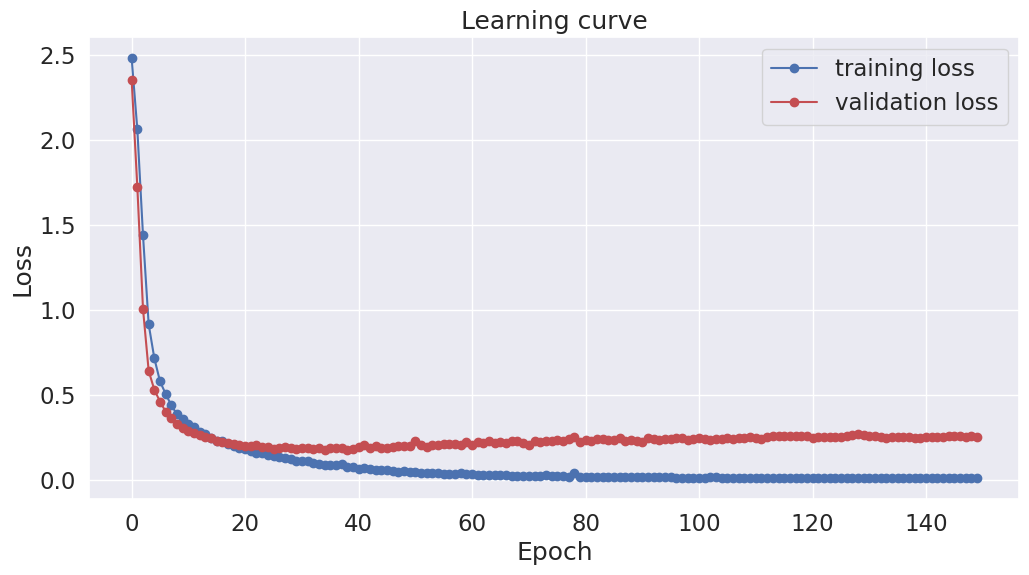

In [22]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Performance on test data

In [23]:
print(test_acc)

[2.3523851235707602, 1.7239963213602703, 1.0053889552752178, 0.6397874454657236, 0.5283158421516418, 0.45911481976509094, 0.3996848265329997, 0.3616352528333664, 0.3272121647993724, 0.30280592540899914, 0.2838307172060013, 0.2710712303717931, 0.2643446971972783, 0.24925746272007623, 0.24392877767483392, 0.2264553407828013, 0.22274698813756308, 0.21319792419672012, 0.21074565003315607, 0.20602083951234818, 0.1963227316737175, 0.19685679177443186, 0.2031617909669876, 0.18969908356666565, 0.1893036092321078, 0.1820245881875356, 0.18471098442872366, 0.18951709692676863, 0.18360045552253723, 0.18064389129479727, 0.18539172410964966, 0.1862731712559859, 0.18173267816503844, 0.1864977888762951, 0.17658403888344765, 0.1839266816775004, 0.1855617215236028, 0.18851852541168532, 0.17251109580198923, 0.1819466066857179, 0.19255790611108145, 0.20064320415258408, 0.18306256458163261, 0.1982023393114408, 0.18292989085117975, 0.18814545373121896, 0.1923218915859858, 0.1964807783563932, 0.1968316348890

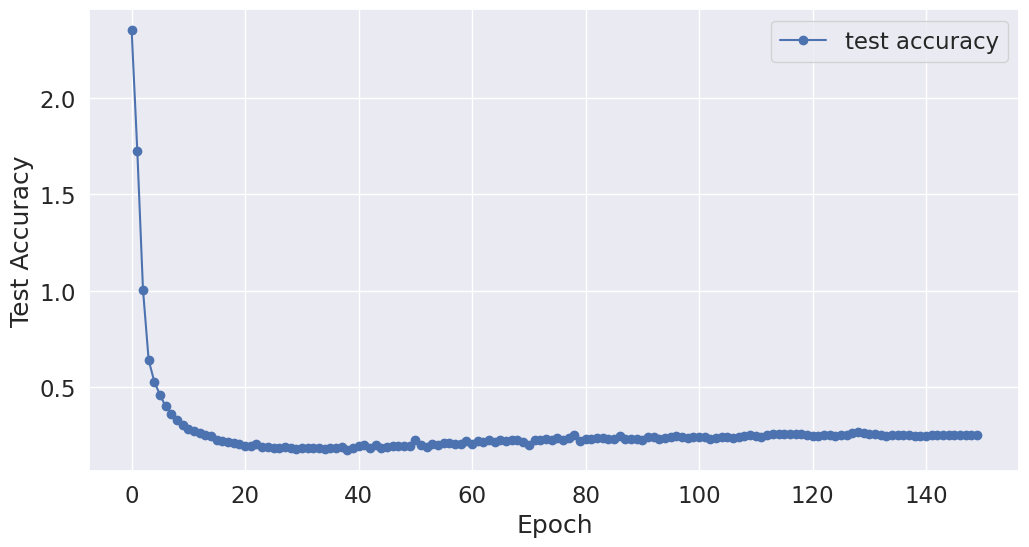

In [24]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(test_acc, 'b-o', label="test accuracy")


# Label the plot.
plt.title("")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.legend()

plt.show()

In [28]:
q = 1
print(acc(False, q))
acc(True, q)


94 0.9529411764705882
0.7903064430426745
___________________0___________________

Predict labels:  ['0', '0', 'R', 'R', 'R', 'R', 'R', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', 'C', 'C', 'C', 'C-cont', 'C-cont', 'C-cont', 'C-cont', '0', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', 'R', 'R', 'R', 'R', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'C', 'C', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', 'C', 'C', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', 'R', 'R', 'R', 'R', 'R', 'R', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0']
Actual labels: 

___________________27___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', 'M', '0', 'M', '0', 'M', '0', 'M', 'M', '0', 'M', '0', 'M', 'M', '0', 'M', '0', 'M', '0', 'M', 'M', '0', 'M', 'M', '0', 'M', 'M', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', 'R', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', '0', '0', '0', '0', 'Q', 'Q', 'Q-cont', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', 'M', '0', 'M', '0', 'M', '0', 'M', 'M', '0', 'M', '0', 'M', 'M', '0', 'M', '0', 'M', '0', 'M', 'M', '0', 'M', 'M', '0', 'M', 'M', '0', '0', 'M'

___________________54___________________

Predict labels:  ['0', 'M', 'M', 'M', 'M', 'M', '0', '0', '0', '0', 'A', 'A', '0', '0', '0', '0', '0', 'A', 'A', 'A-cont', '0', '0', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q-cont', '0', '0', '0', '0', 'M', 'M', 'M', 'M', '0', 'M', 'M', 'M', 'M', '0', '0', '0', 'M', 'M', 'M', '0', '0', '0', '0', '0', 'A', 'A', 'A-cont', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'A', 'A', 'A-cont', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'A', 'A', 'A']
Actual labels:  ['0', '0', 'M', 'M', 'M', 'M', 'M', '0', '0', '0', '0', 'A', 'A', '0', '0', '0', '0', '0', 'A', 'A', 'A-cont', '0', '0', 'Q', 'Q', 'Q', 'Q', 'Q', 'Q-cont', '0', '0', '0', '0', 'M', 'M', 'M', 'M', '0', 'M', 'M', 'M', 'M', '0', '0', '0', 'M', 'M', 'M', '0', '0', '0', '0', '0', 'A', 'A', 'A-cont', '0', '0', 'Q', 'Q-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'A', 'A', 'A-cont', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'A', 'A', 'A', '0']


_

___________________81___________________

Predict labels:  ['0', '0', '0', '0', '0', 'M', 'M', 'M', '0', 'M', 'M', 'M', '0', '0', '0', '0', '0', '0', 'A', 'A', 'A', 'A', 'A', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', '0', 'M', '0', 'M', '0', '0', '0', '0', 'Q', '0', '0', 'C', 'C', 'C', '0', 'A', 'A', 'A-cont', 'A-cont', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', 'M', '0', 'A', 'A', 'A', 'A-cont', 'A-cont', 'A-cont', '0', '0', '0', '0', 'A', 'A', 'A-cont', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', 'M', 'M', 'M', '0', 'M', 'M', 'M', '0', '0', '0', '0', '0', '0', 'A', 'A', 'A', 'A', 'A', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q-cont', 'Q-cont', '0', 'M', '0', 'M', '0', '0', '0', '0', 'Q', '0', '0', 'C', 'C', 'C'

___________________108___________________

Predict labels:  ['0', '0', '0', '0', '0', 'A', 'A', 'A', 'A', '0', 'A', 'A', 'A', 'A', '0', '0', '0', '0', 'A', 'A', 'A', 'A', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q-cont', 'A', 'A', 'A-cont', '0', '0', '0', '0', 'M', 'M', 'M', 'M', 'M', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', '0', 'M', 'M', '0', '0', 'M', 'M', 'M', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', 'M', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', 'A', 'A', 'A', 'A', '0', 'A', 'A', 'A', 'A', '0', '0', '0', '0', 'A', 'A', 'A', 'A', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q-cont', 'A', 'A', 'A-cont', '0', '0', '0', '0', 'M', 'M', 'M', 'M', 'M', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', '0', 'M', 'M', '0', '0', 'M', 'M', 'M', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', 'M

___________________135___________________

Predict labels:  ['M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', '0', 'Q', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', 'Q', 'Q-cont', 'Q-cont', 'Q-cont', 'Q-cont', '0', '0', 'M', 'M', '0', '0', 'M', 'M', 'M', 'M', 'M', '0', '0', '0', '0', '0', '0', 'R', 'R', 'R', 'R', 'R', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', 'Q', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', 'M', 'M', 'M', '0', '0', '0', '0', '0', '0', '0', 'R', 'R', 'R', 'R', '0', '0', '0', '0', '0', '0', 'R', 'R', '0', '0', '0', '0', 'R', 'R', 'R', 'R', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'R', 'R', 'R', 'R',

___________________161___________________

Predict labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', 'M', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', '0', '0', '0', '0', '0', '0', '0', '0']
Actual labels:  ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'M', '0', '0', 'M', '0', 'M', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'Q', 'Q', 'Q', '0', '0', '0', '0', '0', '0', '0', '0', '0']


94 0.9529411764705882


0.7903064430426745

In [26]:
print(acc(False, 112))

94 0.9529411764705882
0.7903064430426745


In [27]:
model = torch.load("test.ck")
model.eval()

print(acc(False))
print(acc(True))

EOFError: Ran out of input